In [39]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import tensorflow as tf

import keras
from keras.utils import load_img, img_to_array
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics

from keras.models import model_from_json
import matplotlib.pyplot as plt

mat = scipy.io.loadmat('./data/IMDB/wiki_crop/wiki.mat')

In [2]:
instances = mat['wiki'][0][0][0].shape[1]
 
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]
 
import pandas as pd
import numpy as np
df = pd.DataFrame(index = range(0,instances), columns = columns)
 
for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
        for j in range(len(current_array)):
            df[columns[j]] = pd.DataFrame(current_array[j][0])

df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN


In [3]:
df['gender'].value_counts().sort_index()

0.0    12622
1.0    47063
Name: gender, dtype: int64

In [4]:
classes = 2 #man woman
print("number of output classes: ",classes)

number of output classes:  2


In [5]:

def datenum_to_datetime(datenum):
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) \
        + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
        + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) \
        - timedelta(days=366)
    
    return exact_date.year
 
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

In [6]:
df['age'] = df['photo_taken'] - df['date_of_birth']

In [7]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]
 
#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]
 
#check threshold
df = df[df['face_score'] >= 3]
 
#some records do not have a gender information
df = df[~df['gender'].isna()]
 
df = df.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])

In [8]:
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]
 
#some guys seem to be unborn in the data set
df = df[df['age'] > 0]

### Feature extraction from Images

In [9]:
target_size = (224, 224)
 
def getImagePixels(image_path):
    img = load_img("./data/IMDB/wiki_crop/%s" % image_path[0], grayscale=False, target_size=target_size)
    x = img_to_array(img).reshape(1, -1)[0]
    #x = preprocess_input(x)
    return x
 
df['pixels'] = df['full_path'].apply(getImagePixels)

In [10]:
target = df['gender'].values
target_classes = keras.utils.to_categorical(target, classes)

In [11]:
features = []
 
for i in range(0, df.shape[0]):
    features.append(df['pixels'].values[i])
    
features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

In [12]:
features.shape

(22138, 224, 224, 3)

In [13]:
features /= 255 #normalize in [0, 1]

In [14]:
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.30)

### Training

In [ ]:
#VGG-Face model
# gpu_options = tf.GPUOptions(allow_growth=True)
# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [15]:
model = keras.Sequential()
model.add(keras.layers.ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(keras.layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))

In [16]:
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(128, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))

In [17]:
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))

In [18]:
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))

In [19]:
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.ZeroPadding2D((1,1)))
model.add(keras.layers.Convolution2D(512, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2), strides=(2,2)))

In [20]:
model.add(keras.layers.Convolution2D(4096, (7, 7), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Convolution2D(4096, (1, 1), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Convolution2D(2622, (1, 1)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Activation('softmax'))

In [21]:
#pre-trained weights of vgg-face model.
#you can find it here: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#related blog post: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
model.load_weights('./weights/VGG-Face/vgg_face_weights.h5')

In [22]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

gender_model = Model(inputs=model.input, outputs=base_model_output)

In [24]:
#check trainable layers
check = False
if check:
    for layer in model.layers:
        print(layer, layer.trainable)
    
    print("------------------------")
    for layer in age_model.layers:
        print(layer, layer.trainable)

In [25]:
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

gender_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']
                 )

c:\Users\EzLaser\anaconda3\envs\DeepfaceVE\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [63]:
checkpointer = ModelCheckpoint(
    filepath='./weights/VGG-Face/classification_gender_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

In [64]:
scores = []

In [65]:
enableFit = True

if enableFit:
    epochs = 250
    batch_size = 256

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = gender_model.fit(
            train_x[ix_train], train_y[ix_train]
            , epochs=1
            , validation_data=(test_x, test_y)
            , callbacks=[checkpointer]
        )
        
        scores.append(score)
        
        from keras.models import load_model
        gender_model = load_model("./weights/VGG-Face/classification_gender_model.hdf5")
        
        gender_model.save_weights('./weights/VGG-Face/gender_model_weights.h5')
        
else:
    #pre-trained weights for gender prediction: https://drive.google.com/file/d/1wUXRVlbsni2FN9-jkS_f4UTUrm1bRLyk/view?usp=sharing
    gender_model.load_weights("./weights/VGG-Face/gender_model_weights.h5")

epoch  0
8/8 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9727
Epoch 1: val_loss improved from inf to 0.05544, saving model to ./weights/VGG-Face\classification_gender_model.hdf5
8/8 [==============================] - 705s 100s/step - loss: 0.1137 - accuracy: 0.9727 - val_loss: 0.0554 - val_accuracy: 0.9887
epoch  1
8/8 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9805
Epoch 1: val_loss improved from 0.05544 to 0.05522, saving model to ./weights/VGG-Face\classification_gender_model.hdf5
8/8 [==============================] - 707s 100s/step - loss: 0.1186 - accuracy: 0.9805 - val_loss: 0.0552 - val_accuracy: 0.9878
epoch  2
8/8 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9961 
Epoch 1: val_loss did not improve from 0.05522
8/8 [==============================] - 674s 95s/step - loss: 0.0055 - accuracy: 0.9961 - val_loss: 0.0567 - val_accuracy: 0.9858
epoch  3
8/8 [==============================] - ETA: 0s -

KeyboardInterrupt: 

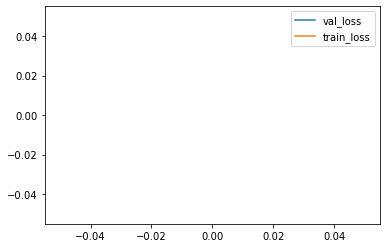

In [32]:
val_loss_change = []; loss_change = []
for i in range(0, len(scores)):
    val_loss_change.append(scores[i].history['val_loss'])
    loss_change.append(scores[i].history['loss'])

plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

### Testing

In [33]:
#loss and accuracy on validation set
gender_model.evaluate(test_x, test_y, verbose=1)

208/208 [==============================] - 617s 3s/step - loss: 0.0421 - accuracy: 0.9887


[0.04211636260151863, 0.9887081980705261]

In [34]:
predictions = gender_model.predict(test_x)

208/208 [==============================] - 624s 3s/step


In [35]:
from sklearn.metrics import classification_report, confusion_matrix

pred_list = []; actual_list = []

for i in predictions:
    pred_list.append(np.argmax(i))

for i in test_y: 
    actual_list.append(np.argmax(i))

confusion_matrix(actual_list, pred_list)

array([[1936,   41],
       [  34, 4631]], dtype=int64)

### Test Model

In [36]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


In [42]:
def loadImage(filepath):
    test_img = load_img(filepath, target_size=(224, 224))
    test_img = img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    test_img /= 255
    return test_img

In [60]:
picture = "./additional-data/tzuyu-1.jpg"

img = load_img(picture)#, target_size=(224, 224))
prediction = gender_model.predict(loadImage(picture))

1/1 [==============================] - 0s 135ms/step


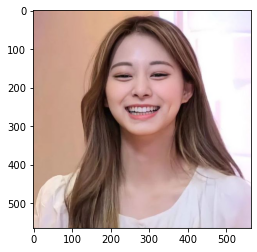

gender:  Woman


In [61]:
plt.imshow(img)
plt.show()

gender = "Man" if np.argmax(prediction) == 1 else "Woman"
print("gender: ", gender)